In [2]:
import gymnasium as gym
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import imageio
import time

from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

In [14]:
# Numero di ambienti paralleli per il training
NUM_ENVS = 4

# Wrapper personalizzato per applicare la ricompensa modificata
class CustomRewardWrapper(gym.Wrapper):
    """
    Un wrapper personalizzato per modificare la ricompensa dell'ambiente HalfCheetah.
    Aggiunge una penalità quando l'agente "cappotta" (ovvero quando l'angolo del torso è troppo inclinato).
    """

    def __init__(self, env):
        """
        Inizializza il wrapper, impostando l'ambiente originale e variabili aggiuntive.

        Parametri:
        - env: L'ambiente di base (HalfCheetah-v5) che sarà avvolto da questo wrapper.
        """
        super().__init__(env)
        self.cappottato_start_time = None  # Variabile per monitorare il tempo di "cappottamento"

    def step(self, action):
        """
        Esegue un passo nell'ambiente con l'azione data e restituisce le nuove osservazioni,
        la ricompensa, e i segnali di terminazione (successo, errore o timeout).

        Parametri:
        - action: L'azione da eseguire nell'ambiente.

        Ritorna:
        - obs: Le nuove osservazioni dell'ambiente.
        - reward: La ricompensa ottenuta per l'azione eseguita.
        - terminated: Un segnale che indica se l'episodio è terminato (successo o errore).
        - truncated: Un segnale che indica se l'episodio è stato troncato (timeout o condizioni specifiche).
        - info: Dati aggiuntivi sull'episodio (di solito informazioni di debug).
        """

        # Passa l'azione all'ambiente e ottieni le nuove osservazioni e ricompensa
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Ottieni l'angolo del torso (per determinare se il modello è caduto)
        torso_angle = self.env.unwrapped.data.qpos[2]

        # Se l'angolo del torso è sotto una certa soglia, il modello è "cappottato"
        if torso_angle < -0.7:
            if self.cappottato_start_time is None:
                self.cappottato_start_time = time.time()  # Registra il tempo del cappottamento
            # Calcola la penalità in base al tempo di cappottamento
            tempo_cappottato = time.time() - self.cappottato_start_time
            penalty = 50 * tempo_cappottato  # Penalità crescente
            reward -= penalty  # Applica la penalità alla ricompensa
        else:
            self.cappottato_start_time = None  # Resetta il timer quando non è più cappottato

        return obs, reward, terminated, truncated, info

# Funzione per creare l'ambiente HalfCheetah con parametri personalizzati
def make_env():
    """
    Crea e restituisce un ambiente HalfCheetah con parametri personalizzati per il training.
    """
    def _init():
        # Crea l'ambiente HalfCheetah con parametri specifici
        env = gym.make("HalfCheetah-v5",
                        reset_noise_scale=0.13635555699602933,
                        forward_reward_weight=0.7151140526343989,
                        ctrl_cost_weight=0.19342622590821706)
        env = Monitor(env)  # Aggiungi il monitor per registrare le metriche
        env = CustomRewardWrapper(env)  # Applica il wrapper personalizzato per la ricompensa
        return env
    return _init

# Creazione degli ambienti per il training utilizzando SubprocVecEnv per eseguire il training in parallelo
env = SubprocVecEnv([make_env() for _ in range(NUM_ENVS)])  # Creazione di NUM_ENVS ambienti paralleli
env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)  # Normalizzazione delle osservazioni

# Selezione automatica del dispositivo (GPU se disponibile, altrimenti CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Parametri del modello SAC
model_params = {
    "policy": "MlpPolicy",  # Politica Multi-layer perceptron
    "env": env,  # Ambiente di addestramento
    "learning_rate": 4.3539588088977104e-05,  # Tasso di apprendimento
    "buffer_size": 500000,  # Dimensione del buffer di esperienza
    "batch_size": 256,  # Dimensione del batch per l'addestramento
    "tau": 0.013929154106819306,  # Parametro per il soft update delle reti
    "gamma": 0.9843911115842067,  # Fattore di sconto
    "train_freq": 1,  # Frequenza di aggiornamento del modello
    "gradient_steps": 8,  # Numero di passaggi per l'aggiornamento del gradiente
    "ent_coef": 0.001,  # Coefficiente di entropia
    "verbose": 1,  # Output verboso per il monitoraggio del training
    "tensorboard_log": "./sac_HalfCheetah_tensorboard/",  # Percorso per il log di TensorBoard
    "device": device,  # Dispositivo per il training (CPU o GPU)
    "policy_kwargs": dict(net_arch=[256, 256, 128])  # Architettura della rete neurale
}

# Creazione dell'ambiente di valutazione per testare il modello addestrato
eval_env = DummyVecEnv([make_env()])  # Usa DummyVecEnv per l'ambiente di valutazione
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10., training=False)  # Normalizzazione delle osservazioni

# Callback per la valutazione del modello e salvataggio dei migliori modelli
eval_callback = EvalCallback(eval_env, best_model_save_path="./logs/best_model",
                             log_path="./logs/", eval_freq=5000, deterministic=True, render=False)

# Callback per il salvataggio dei checkpoint durante l'allenamento
checkpoint_callback = CheckpointCallback(save_freq=5000, save_path="./logs/checkpoints/",
                                         name_prefix="sac_halfcheetah_checkpoint")

# Creazione e training del modello SAC con i parametri definiti
model = SAC(**model_params)
model.learn(total_timesteps=1_500_000, callback=CallbackList([eval_callback, checkpoint_callback]))

# Salvataggio del modello e dei parametri di normalizzazione
model.save("sac_HalfCheetah_model")  # Salva il modello addestrato
env.save("vecnormalize_HalfCheetah.pkl")  # Salva i parametri di normalizzazione

# Caricamento del modello e dei parametri di normalizzazione per la valutazione
model = SAC.load("sac_HalfCheetah_model", device=device)  # Carica il modello addestrato
eval_env = VecNormalize.load("vecnormalize_HalfCheetah.pkl", eval_env)  # Carica i parametri di normalizzazione
eval_env.training = False  # Disabilita la normalizzazione per la valutazione
eval_env.reset()  # Reset dell'ambiente di valutazione

# Funzione per la valutazione del modello
def evaluate_agent(model, env, episodes=100):
    """
    Valuta le performance dell'agente su un certo numero di episodi.

    Parametri:
    - model: Il modello addestrato da valutare.
    - env: L'ambiente di valutazione.
    - episodes: Numero di episodi per la valutazione.

    Ritorna:
    - La ricompensa media e la deviazione standard delle ricompense ottenute.
    """
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=episodes, deterministic=True)
    print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    return mean_reward, std_reward

# Valutazione del modello addestrato
mean_reward_trained, std_reward_trained = evaluate_agent(model, eval_env, episodes=100)


Using cpu device
Logging to ./sac_HalfCheetah_tensorboard/SAC_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -256     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 82       |
|    time_elapsed    | 48       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 4.5      |
|    critic_loss     | 0.03     |
|    ent_coef        | 0.001    |
|    learning_rate   | 4.35e-05 |
|    n_updates       | 7792     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -78.8    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 85       |
|    time_elapsed    | 93       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -5.09    |
|    critic_loss  

In [15]:
# Salvataggio del modello addestrato
model.save("sac_HalfCheetah_model")
# Salviamo il modello addestrato in un file chiamato 'sac_HalfCheetah_model'
# Questo file conterrà tutti i parametri e le configurazioni del modello SAC che sono stati allenati.

# Salvataggio dei parametri di normalizzazione
env.save("vecnormalize_HalfCheetah.pkl")
# Salviamo i parametri di normalizzazione dell'ambiente in un file chiamato 'vecnormalize_HalfCheetah.pkl'
# Questo file contiene le statistiche di normalizzazione delle osservazioni (norm_obs) e delle ricompense (norm_reward)
# che sono state applicate durante l'allenamento, così che possano essere riutilizzati per mantenere la coerenza
# durante la fase di valutazione o inferenza.



Caricando dati da: ./sac_HalfCheetah_tensorboard/SAC_2


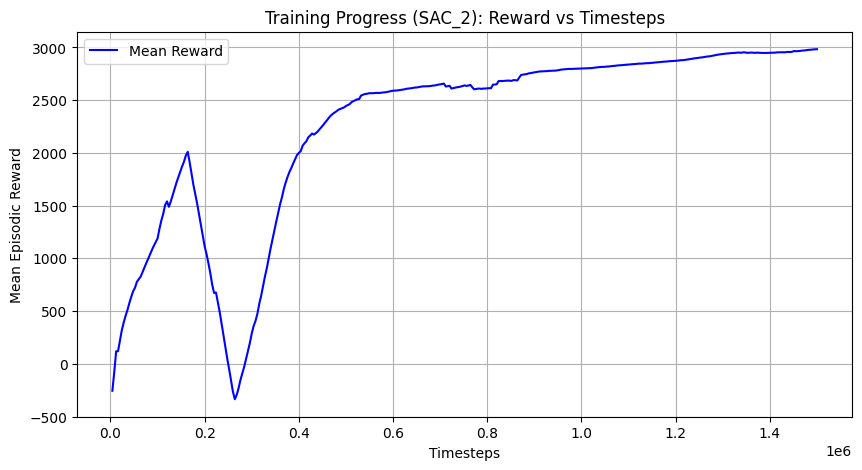

In [3]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Percorso principale della cartella di log di TensorBoard
log_dir = "./sac_HalfCheetah_tensorboard/"

# Specifica manualmente quale sottocartella utilizzare per i dati di TensorBoard
selected_subdir = "SAC_2"  # Cambia il nome della sottocartella in base alla versione

# Percorso completo della sottocartella selezionata
selected_path = os.path.join(log_dir, selected_subdir)

# Verifica che la sottocartella esista
if not os.path.exists(selected_path):
    raise FileNotFoundError(f"La cartella {selected_subdir} non esiste in {log_dir}")

# Conferma il percorso di caricamento dei dati
print(f"Caricando dati da: {selected_path}")

# Trova il file degli eventi di TensorBoard all'interno della sottocartella selezionata
event_file = None
for root, dirs, files in os.walk(selected_path):
    for file in files:
        if "events.out.tfevents" in file:  # Cerca il file degli eventi
            event_file = os.path.join(root, file)
            break

# Verifica che sia stato trovato almeno un file degli eventi
if event_file is None:
    raise FileNotFoundError(f"Nessun file TensorBoard trovato in {selected_path}")

# Carica i dati dal file degli eventi di TensorBoard
event_acc = EventAccumulator(event_file)
event_acc.Reload()

# Estrai i dati relativi ai timesteps e alle ricompense medie
timesteps = []
mean_rewards = []

# Estrai le ricompense medie per ogni passo (step) nel training
for event in event_acc.Scalars("rollout/ep_rew_mean"):
    timesteps.append(event.step)
    mean_rewards.append(event.value)

# Creazione del grafico per visualizzare il progresso dell'allenamento
plt.figure(figsize=(10, 5))
plt.plot(timesteps, mean_rewards, label="Mean Reward", color="blue")
plt.xlabel("Timesteps")  # Etichetta per l'asse x (numero di passi)
plt.ylabel("Mean Episodic Reward")  # Etichetta per l'asse y (ricompensa media per episodio)
plt.title(f"Training Progress ({selected_subdir}): Reward vs Timesteps")  # Titolo del grafico
plt.legend()  # Legenda per il grafico
plt.grid(True)  # Mostra la griglia
plt.show()  # Mostra il grafico


Trained Policy: Mean Reward: 3001.31 ± 83.02
Random Policy: Mean Reward: -457.79 ± 52.60


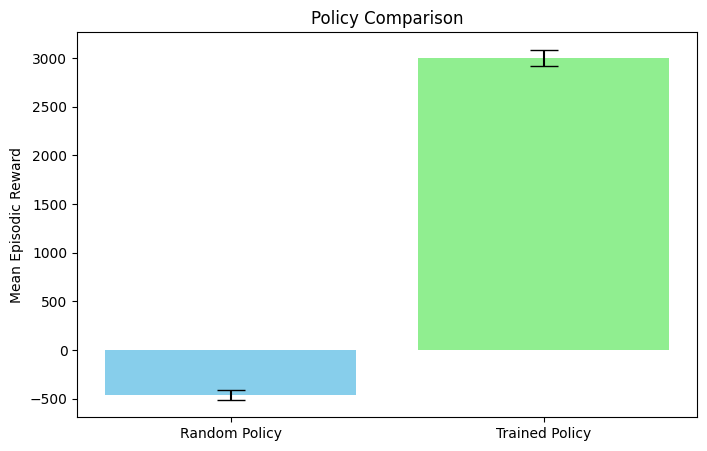

In [4]:
# Percorsi dei file salvati
model_path = "./sac_HalfCheetah_model.zip"
vecnormalize_path = "./vecnormalize_HalfCheetah.pkl"

# Verifica che i file esistano prima di caricarli
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Modello non trovato: {model_path}")
if not os.path.exists(vecnormalize_path):
    raise FileNotFoundError(f"File di normalizzazione non trovato: {vecnormalize_path}")

# Selezione automatica del dispositivo (CPU o GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Caricamento del modello addestrato
model = SAC.load(model_path, device=device)

# Wrapper personalizzato per applicare la ricompensa modificata in caso di caduta
class CustomRewardWrapper(gym.Wrapper):
    """
    Questo wrapper personalizzato applica una penalità se l'agente cade.
    La penalità aumenta nel tempo che l'agente resta in caduta.

    Attributi:
    - cappottato_start_time: tempo in cui l'agente è caduto per la prima volta.
    """

    def __init__(self, env):
        """
        Inizializza il wrapper, salvando l'ambiente di base.
        """
        super().__init__(env)

    def step(self, action):
        """
        Esegue un passo nell'ambiente, applicando la penalità se l'agente è caduto.

        Parametri:
        - action: l'azione scelta dall'agente.

        Ritorna:
        - obs: le nuove osservazioni.
        - reward: la ricompensa modificata.
        - terminated: se l'episodio è terminato.
        - truncated: se l'episodio è stato troncato.
        - info: informazioni aggiuntive sull'ambiente.
        """
        # Passo base nell'ambiente
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Angolo del torso per determinare se l'agente è caduto
        torso_angle = self.env.unwrapped.data.qpos[2]

        if not hasattr(self, 'cappottato_start_time'):  # Inizializza al primo step
            self.cappottato_start_time = None

        if torso_angle < -0.7:  # Se è caduto
            if self.cappottato_start_time is None:  # Se è la prima volta che cade
                self.cappottato_start_time = time.time()  # Registra il tempo

            # Calcola la durata della caduta
            tempo_cappottato = time.time() - self.cappottato_start_time

            # Penalità cumulativa basata sul tempo in caduta
            penalty = 50 * tempo_cappottato
            reward -= penalty  # Applica la penalità alla ricompensa

        else:  # Se non è più caduto
            self.cappottato_start_time = None  # Resetta il timer della caduta

        return obs, reward, terminated, truncated, info

# Funzione per creare un ambiente con il wrapper personalizzato
def make_env():
    """
    Crea e restituisce un nuovo ambiente HalfCheetah-v5 con la normalizzazione e la ricompensa personalizzata.

    Ritorna:
    - Una funzione che inizializza l'ambiente.
    """
    def _init():
        env = gym.make("HalfCheetah-v5",
                        reset_noise_scale=0.13635555699602933,
                        forward_reward_weight=0.7151140526343989,
                        ctrl_cost_weight=0.19342622590821706)
        env = Monitor(env)  # Monitorizza l'ambiente per salvare le informazioni sugli episodi
        env = CustomRewardWrapper(env)  # Applica il wrapper personalizzato
        return env
    return _init

# Creazione dell'ambiente di valutazione
eval_env = DummyVecEnv([make_env()])
eval_env = VecNormalize.load(vecnormalize_path, eval_env)  # Carica la normalizzazione
eval_env.training = False  # Disabilita la normalizzazione in fase di test
eval_env.reset()

# Funzione per valutare una policy casuale
def evaluate_random_policy(env, episodes=100):
    """
    Valuta una policy casuale su un ambiente vettorizzato.

    Parametri:
    - env: L'ambiente di simulazione (normalizzato e vettorizzato).
    - episodes: Numero di episodi da eseguire per la valutazione.

    Ritorna:
    - La ricompensa media e la deviazione standard delle ricompense ottenute.
    """
    total_rewards = []
    for _ in range(episodes):
        obs = env.reset()
        done = [False] * env.num_envs
        episode_rewards = np.zeros(env.num_envs)
        while not all(done):
            # Esegui azioni casuali per ciascun ambiente
            actions = [env.action_space.sample() for _ in range(env.num_envs)]
            obs, rewards, done, _ = env.step(actions)
            episode_rewards += rewards
        total_rewards.extend(episode_rewards)

    # Calcola la ricompensa media e la deviazione standard
    mean_reward_random = np.mean(total_rewards)
    std_reward_random = np.std(total_rewards)
    return mean_reward_random, std_reward_random

# Valutazione della policy addestrata
mean_reward_trained, std_reward_trained = evaluate_policy(model, eval_env, n_eval_episodes=100, deterministic=True)

# Valutazione della policy casuale
mean_reward_random, std_reward_random = evaluate_random_policy(eval_env, episodes=100)

# Stampa dei risultati
print(f"Trained Policy: Mean Reward: {mean_reward_trained:.2f} ± {std_reward_trained:.2f}")
print(f"Random Policy: Mean Reward: {mean_reward_random:.2f} ± {std_reward_random:.2f}")

# Creazione del grafico di confronto tra la policy addestrata e quella casuale
labels = ['Random Policy', 'Trained Policy']
means = [mean_reward_random, mean_reward_trained]
stds = [std_reward_random, std_reward_trained]

plt.figure(figsize=(8, 5))
plt.bar(labels, means, yerr=stds, capsize=10, color=['skyblue', 'lightgreen'])
plt.ylabel('Mean Episodic Reward')
plt.title('Policy Comparison')
plt.show()